<a href="https://colab.research.google.com/github/isismeira/classificador_algarismos_manuscritos/blob/main/classificacao_algarismos_manuscritos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de algarismos escritos à mão

## Algumas importações

In [1]:
import sys
import numpy as np
import os
np.random.seed(42)

## Conhecendo o dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, Y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
Y.shape

(70000,)

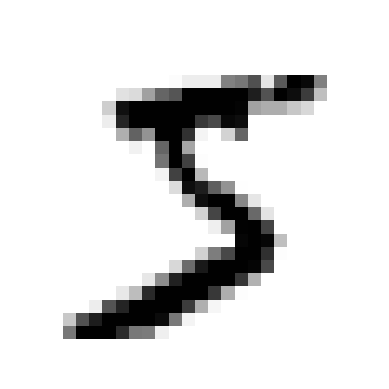

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

algum_digito = X.iloc[0].values
imagem_algum_digito = algum_digito.reshape(28, 28)

plt.imshow(imagem_algum_digito, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
Y[127]

'4'

In [8]:
Y = Y.astype(np.uint8)

Separando entre treino e teste...

In [9]:
X_treino, X_teste, Y_treino, Y_teste = X[:60000], X[60000:], Y[:60000], Y[60000:]

## Classificação Binária (apenas um algarismo)

In [10]:
Y_treino_5 = (Y_treino == 5)
Y_teste_5 = (Y_teste == 5)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)
sgd.fit(X_treino, Y_treino_5)

SGDClassifier(random_state=42)

In [12]:
sgd.predict([algum_digito])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

### Desempenho do classificador binário com o método k-fold

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_treino, Y_treino_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.base import BaseEstimator

class Classificador_Nao_5(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
nao_5 = Classificador_Nao_5()
cross_val_score(nao_5, X_treino, Y_treino_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Desempenho do classificador binário com matriz de confusão

In [16]:
from sklearn.model_selection import cross_val_predict

Y_treino_pred = cross_val_predict(sgd, X_treino, Y_treino_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

matriz_confusao = confusion_matrix(Y_treino_5, Y_treino_pred)
matriz_confusao

array([[53892,   687],
       [ 1891,  3530]])

### Desempenho do classificador binário com precisão e revocação

In [18]:
from sklearn.metrics import precision_score, recall_score

In [19]:
precision_score(Y_treino_5, Y_treino_pred)

0.8370879772350012

In [20]:
recall_score(Y_treino_5, Y_treino_pred)

0.6511713705958311

In [21]:
from sklearn.metrics import f1_score
f1_score(Y_treino_5, Y_treino_pred)

0.7325171197343847

### Trade-off precisão/revocação

In [22]:
Y_scores = sgd.decision_function([algum_digito])
Y_scores

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [23]:
limiar = 0
Y_algum_digito_pred = (Y_scores > limiar)
Y_algum_digito_pred

array([ True])

In [24]:
limiar = 8000
Y_algum_digito_pred = (Y_scores > limiar)
Y_algum_digito_pred

array([False])

In [25]:
Y_scores = cross_val_predict(sgd, X_treino, Y_treino_5, cv=3, method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisao, revocacao, limiar = precision_recall_curve(Y_treino_5, Y_scores)

In [27]:
def plot_precisao_revocacao_vs_limiar(precisao, revocacao, limiar):
    plt.plot(limiar, precisao[:-1], "b--", label="Precisão", linewidth=2)
    plt.plot(limiar, revocacao[:-1], "g-", label="Revocação", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Limiar", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


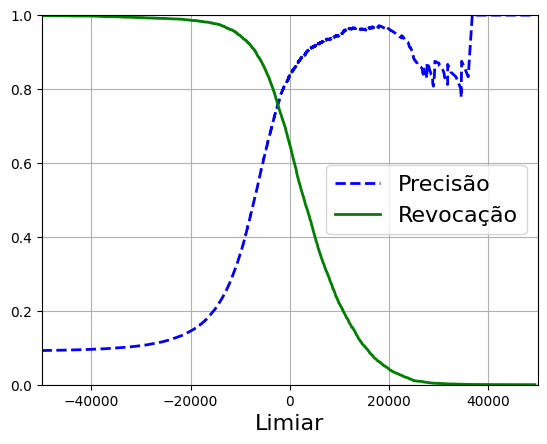

In [28]:
plot_precisao_revocacao_vs_limiar(precisao, revocacao, limiar)
plt.show()

In [29]:
def plot_precisao_vs_revocacao(precisao, revocacao):
    plt.plot(revocacao, precisao, "b-", linewidth=2)
    plt.xlabel("Revocação", fontsize=16)
    plt.ylabel("Precisão", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

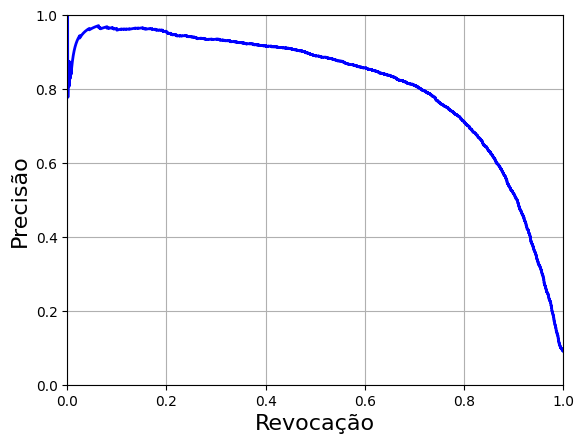

In [30]:
plot_precisao_vs_revocacao(precisao, revocacao)
plt.show()

In [31]:
limiar_90_precisao = limiar[np.argmax(precisao >= 0.90)]

In [32]:
Y_treino_pred_90 = (Y_scores >= limiar_90_precisao)

In [33]:
precision_score(Y_treino_5, Y_treino_pred_90)

0.9000345901072293

In [34]:
recall_score(Y_treino_5, Y_treino_pred_90)

0.4799852425751706

### A curva ROC

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, limiar = roc_curve(Y_treino_5, Y_scores)

In [41]:
def plot_curva_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falsos positivos ', fontsize=16)
    plt.ylabel('Taxa de verdadeiros positivos', fontsize=16)
    plt.grid(True)

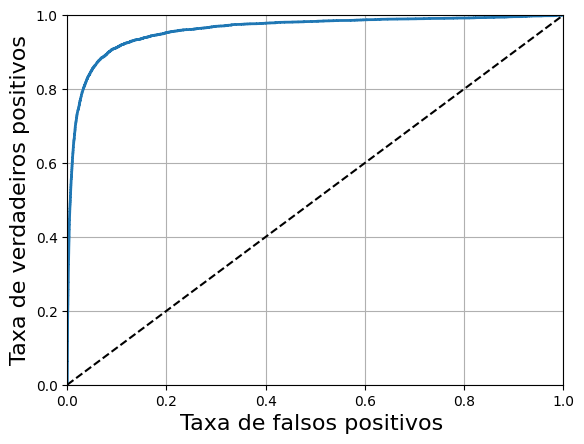

In [42]:
plot_curva_roc(fpr, tpr)
plt.show()

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_treino_5, Y_scores)

np.float64(0.9604938554008616)

### Comparando curva ROC de Florestas Aleatórias com SGC

In [44]:
from sklearn.ensemble import RandomForestClassifier

floresta = RandomForestClassifier(random_state=42)

In [45]:
Y_proba_floresta = cross_val_predict(floresta, X_treino, Y_treino_5, cv=3, method="predict_proba")

In [46]:
Y_scores_floresta  = Y_proba_floresta[:, 1]
fpr_floresta, tpr_floresta, limiar_floresta = roc_curve(Y_treino_5, Y_scores_floresta)

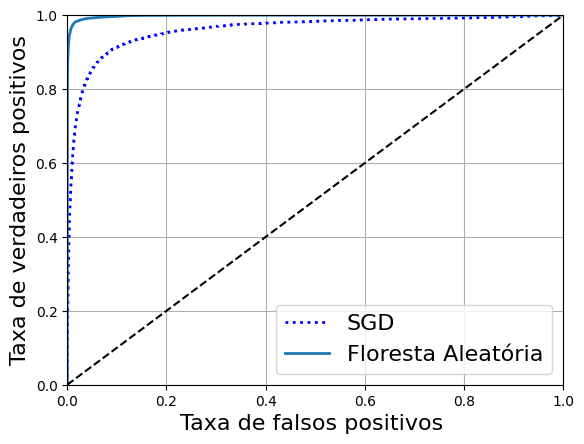

In [48]:
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_curva_roc(fpr_floresta, tpr_floresta, "Floresta Aleatória")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [49]:
roc_auc_score(Y_treino_5, Y_scores_floresta)

np.float64(0.9983436731328145)

## Classificação Multiclasse (todos os algarismos)

In [50]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_treino, Y_treino)
svm.predict([algum_digito])

array([5], dtype=uint8)

In [51]:
algum_digito_scores = svm.decision_function([algum_digito])
algum_digito_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [52]:
np.argmax(algum_digito_scores)

np.int64(5)

In [53]:
from sklearn.multiclass import OneVsRestClassifier

ovr = OneVsRestClassifier(SVC())
ovr.fit(X_treino, Y_treino)
ovr.predict([algum_digito])

array([5], dtype=uint8)

In [54]:
len(ovr.estimators_)

10

In [56]:
sgd.fit(X_treino, Y_treino)
sgd.predict([algum_digito])

array([3], dtype=uint8)

In [57]:
sgd.decision_function([algum_digito])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [58]:
cross_val_score(sgd, X_treino, Y_treino, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_treino_escalado = scaler.fit_transform(X_treino.astype(np.float64))

In [60]:
cross_val_score(sgd, X_treino_escalado, Y_treino, cv=3, scoring="accuracy")

KeyboardInterrupt: 

## Análise de Erro

In [ ]:
Y_treino_pred = cross_val_predict(sgd, X_treino_escalado, Y_treino, cv=3)
confusao = confusion_matrix(Y_treino, Y_treino_pred)
confusao

In [ ]:
plt.matshow(confusao, cmap=plt.cm.gray)
plt.show()

In [ ]:
soma_linha = confusao.sum(axis=1, keepdims=True)
confusao_normalizada = confusao / soma_linha

In [ ]:
np.fill_diagonal(confusao_normalizada, 0)
plt.matshow(confusao_normalizada, cmap=plt.cm.gray)
plt.show()

In [ ]:
def plot_digitos(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)

    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_treino[(Y_treino == cl_a) & (Y_treino_pred == cl_a)]
X_ab = X_treino[(Y_treino == cl_a) & (Y_treino_pred == cl_b)]
X_ba = X_treino[(Y_treino == cl_b) & (Y_treino_pred == cl_a)]
X_bb = X_treino[(Y_treino == cl_b) & (Y_treino_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digitos(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digitos(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digitos(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digitos(X_bb[:25], images_per_row=5)
plt.show()

## Classificação Multirrótulo

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Y_treino_grande = (Y_treino >= 7)
Y_treino_impar = (Y_treino % 2 == 1)
Y_multirrotulo = np.c_[Y_treino_grande, Y_treino_impar]

knn = KNeighborsClassifier()
knn.fit(X_treino, Y_multirrotulo)

In [ ]:
knn.predict([algum_digito])

In [ ]:
Y_treino_knn_pred = cross_val_predict(knn, X_treino, Y_multirrotulo, cv=3)
f1_score(Y_multirrotulo, Y_treino_knn_pred, average="macro")

## Classificação Multioutput

In [ ]:
noise = np.random.randint(0, 100, (len(X_treino), 784))
X_train_mod = X_treino + noise
noise = np.random.randint(0, 100, (len(X_teste), 784))
X_test_mod = X_teste + noise
y_train_mod = X_treino
y_test_mod = X_teste

In [ ]:
some_index = 0
plt.subplot(121); plot_digitos(X_test_mod[some_index])
plt.subplot(122); plot_digitos(y_test_mod[some_index])
plt.show()

In [ ]:
knn.fit(X_train_mod, y_train_mod)
clean_digit = knn.predict([X_test_mod[some_index]])
plot_digitos(clean_digit)